# Online Payment Fraud Detection 🚨💳

## Step 1: Problem Definition, Objectives & Data Overview

### 1.1 Project Background  
Financial fraud—especially in online payments—poses a major risk to businesses and consumers alike. Fraudsters exploit gaps in detection systems, leading to large monetary losses and reputational damage.

### 1.2 Primary Objectives  
1. **Detect** potentially fraudulent transactions in real time.  
2. **Maximize** the capture of true frauds (high recall).  
3. **Minimize** false alarms to avoid blocking legitimate customers (high precision).  
4. **Build** an end-to-end ML pipeline that can be iterated and improved over time.

### 1.3 Key Questions to Answer  
- What transaction patterns most strongly indicate fraud?  
- How imbalanced is our dataset, and how should we handle class imbalance?  
- Which features (amount, transaction type, time step, etc.) carry the most predictive power?

### 1.4 Success Metrics  
| Metric     | Why It Matters                                  | Desired Behavior       |
|------------|-------------------------------------------------|------------------------|
| **Recall** | Catch as many frauds as possible                | ↑ Higher is better     |
| **Precision** | Limit false positives (legitimate flagged)   | ↑ Higher is better     |
| **F1-Score** | Balance between precision and recall          | ↑ Higher is better     |
| **ROC-AUC** | Overall separability of fraud vs. non-fraud   | ↑ Higher is better     |

### 1.5 Dataset Overview  
We’re using the **`jainilcoder/online-payment-fraud-detection`** dataset from Kaggle.  

| Column     | Type      | Description                                            |
|------------|-----------|--------------------------------------------------------|
| `step`     | int       | Discrete time unit (hour) in the simulation            |
| `type`     | object    | Transaction type (`PAYMENT`, `TRANSFER`, etc.)         |
| `amount`   | float     | Amount of transaction                                  |
| `nameOrig` | object    | Customer who initiated the transaction                 |
| `oldbalanceOrg` | float | Balance before the transaction                        |
| `newbalanceOrig` | float | Balance after the transaction                         |
| `nameDest` | object    | Recipient of the transaction                           |
| `oldbalanceDest` | float | Recipient balance before transaction                  |
| `newbalanceDest` | float | Recipient balance after transaction                   |
| `isFraud`  | int (0/1) | Label: **1** = Fraudulent, **0** = Legitimate          |
| `isFlaggedFraud` | int (0/1) | Simulator-generated flag for extremely large transfers |

> **Note:** We’ll drop `isFlaggedFraud` in modeling, since it’s a simulator artifact.

---



In [9]:
# Step 1.4: Setup & Data Loading

# --- 1. Install / authenticate Kaggle API (if using Colab) ---
# !pip install kaggle
# from google.colab import files
# files.upload()  # upload your kaggle.json here

# --- 2. Import core libraries ---
import os
import pandas as pd          # for data manipulation
import numpy as np           # for numerical operations

# Visualization libraries (will use in EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn will be used later for modeling
from sklearn.model_selection import train_test_split

# --- 3. Download & load the dataset ---
# import os
# import kagglehub

# path = kagglehub.dataset_download("jainilcoder/online-payment-fraud-detection")

# # Construct the full file path to the downloaded CSV file.
# file_path = os.path.join(path, "/kaggle/input/online-payment-fraud-detection/onlinefraud.csv")

# Read the csv file into a pandas DataFrame.
# df = pd.read_csv(file_path)

# Assuming the CSV is in the working directory:
data_path = 'D:\flask\fraud_detection_project\onlinefraud.csv'
df = pd.read_csv(data_path)

# Initial Sanity Checks
# -------------------------------------------------
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.\n")
print("Column data types and non-null counts:")
print(df.info(), "\n")
print(" First 5 rows preview:")
display(df.head())

# Quick Statistics
# -------------------------------------------------
print(" Descriptive statistics for numeric features:")
display(df.describe().T)

print("Class distribution (isFraud):")
display(df['isFraud'].value_counts(normalize=True).rename_axis('isFraud').reset_index(name='proportion'))


<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:33: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Amamk\AppData\Local\Temp\ipykernel_24384\1981332128.py:33: SyntaxWarning: invalid escape sequence '\o'
  data_path = 'D:\flask\fraud_detection_project\onlinefraud.csv'
C:\Users\Amamk\AppData\Local\Temp\ipykernel_24384\1981332128.py:33: SyntaxWarning: invalid escape sequence '\o'
  data_path = 'D:\flask\fraud_detection_project\onlinefraud.csv'


OSError: [Errno 22] Invalid argument: 'D:\x0clask\x0craud_detection_project\\onlinefraud.csv'

### Step 1.4: Environment Setup & Data Loading (Detailed)

In this cell, we will:

1. **(Optional)** Install any missing packages (commented out for Colab).  
2. **Import** all required libraries, with a note on their purpose.  
3. **Load** the CSV into a DataFrame, with error handling.  
4. Perform **sanity checks**:
   - Dataset shape  
   - Column data types  
   - Memory usage  
   - Percentage of missing values per column  
   - Count of exact duplicate rows  
5. **Visualize** missing-data patterns with a heatmap.

These steps ensure you fully understand the structure and health of your data before proceeding to EDA.


In [2]:
# ---  Sanity Checks ---
# Shape
n_rows, n_cols = df.shape
print(f"Shape: {n_rows} rows, {n_cols} columns\n")

# Data Types & Non-Null Counts
print("Column info:")
df.info()

# Memory Usage
mem_usage = df.memory_usage(deep=True).sum() / (1024**2)
print(f"\nMemory usage: {mem_usage:.2f} MB\n")

# Missing Values (%)
missing_pct = df.isnull().mean() * 100
print("Missing values (%):")
print(missing_pct.sort_values(ascending=False).round(2), "\n")

# Duplicate Rows
dupes = df.duplicated().sum()
print(f"Duplicate rows: {dupes}\n")

# Preview first 5 rows
print("Data preview:")
display(df.head())


Shape: 6362620 rows, 11 columns

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Memory usage: 1452.57 MB

Missing values (%):
step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64 

Duplicate rows: 0

Data preview:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


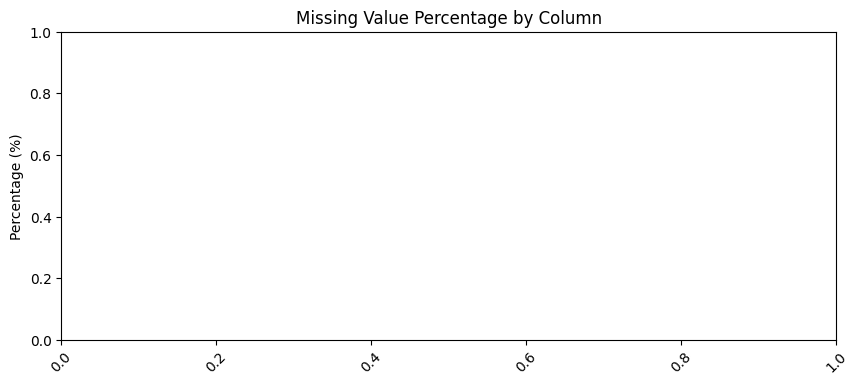

In [3]:
# Optional: Barplot of missing value % by column (if any)
missing_pct = df.isnull().mean() * 100
missing_cols = missing_pct[missing_pct > 0]

plt.figure(figsize=(10, 4))
sns.barplot(x=missing_cols.index, y=missing_cols.values, palette='viridis')
plt.title("Missing Value Percentage by Column")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()


## Step 2: Exploratory Data Analysis & Data Cleaning

### 2.1 Goals of This Step
1. **Understand** each feature’s distribution and relationship to fraud.  
2. **Identify** columns that carry little to no predictive power (e.g., IDs).  
3. **Clean** the data by removing or transforming these columns.  
4. **Prepare** the dataset for modeling (train/test split to come later).

### 2.2 Tasks
1. **Value Counts & Unique Values**  
   - Check `type`, `isFlaggedFraud`, etc., to see if a column is constant or near-constant.  
2. **Drop Non-Informative Columns**  
   - Remove transaction IDs (`nameOrig`, `nameDest`) and simulator flags (`isFlaggedFraud`).  
3. **Convert Data Types**  
   - Ensure categorical columns use the `category` dtype for memory & clarity.  
4. **Visualize**  
   - Bar plots for categorical features.  
   - Histograms for numerical features (e.g., `amount`, balances).  
5. **Correlation Analysis**  
   - Heatmap of correlations among numeric features and with the target (`isFraud`).

> **Note:** All cleaning decisions should follow after we’ve inspected the data distributions.


In [4]:
# --- Value Counts & Uniqueness Checks ---

#  Categorical columns to inspect
cat_cols = ['type', 'isFlaggedFraud']

for col in cat_cols:
    counts = df[col].value_counts(dropna=False)
    pct   = df[col].value_counts(normalize=True, dropna=False) * 100
    print(f"\nColumn `{col}`:\n", pd.concat([counts, pct.rename('percent')], axis=1))




Column `type`:
             count    percent
type                        
CASH_OUT  2237500  35.166331
PAYMENT   2151495  33.814608
CASH_IN   1399284  21.992261
TRANSFER   532909   8.375622
DEBIT       41432   0.651178

Column `isFlaggedFraud`:
                   count    percent
isFlaggedFraud                    
0               6362604  99.999749
1                    16   0.000251


In [5]:
#  Check unique counts for ID‐like columns
id_cols = ['nameOrig', 'nameDest']
for col in id_cols:
    print(f"\nColumn `{col}` has {df[col].nunique()} unique values "
          f"out of {len(df)} total rows "
          f"({df[col].nunique()/len(df)*100:.2f}% unique).")




Column `nameOrig` has 6353307 unique values out of 6362620 total rows (99.85% unique).

Column `nameDest` has 2722362 unique values out of 6362620 total rows (42.79% unique).


In [6]:
# --- Drop Non-Informative Columns ---
# These columns are identifiers or simulator artifacts with no predictive value.
drop_cols = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df_clean = df.drop(columns=drop_cols)
print(f"\n Dropped columns: {drop_cols}")
print("Remaining columns:", df_clean.columns.tolist())



 Dropped columns: ['nameOrig', 'nameDest', 'isFlaggedFraud']
Remaining columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


In [7]:
# --- Convert Data Types ---
df_clean['type'] = df_clean['type'].astype('category')

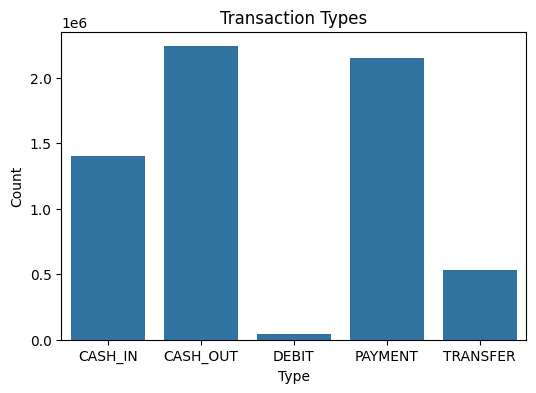

In [8]:
# --- Visualize Categorical Distributions ---
plt.figure(figsize=(6,4))
sns.countplot(x='type', data=df_clean, order=df_clean['type'].cat.categories)
plt.title("Transaction Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


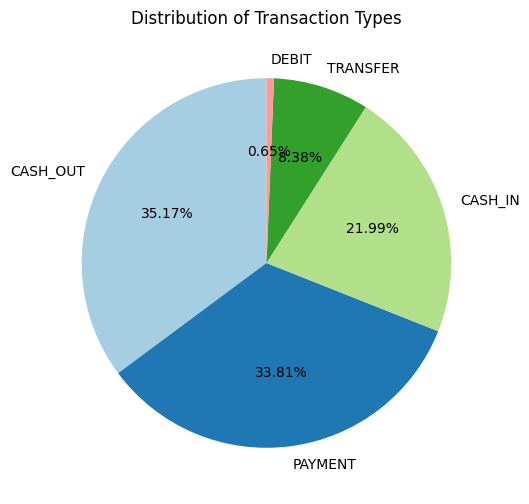

In [9]:
# Pie chart for transaction type distribution
type_counts = df_clean['type'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.2f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Distribution of Transaction Types")
plt.show()

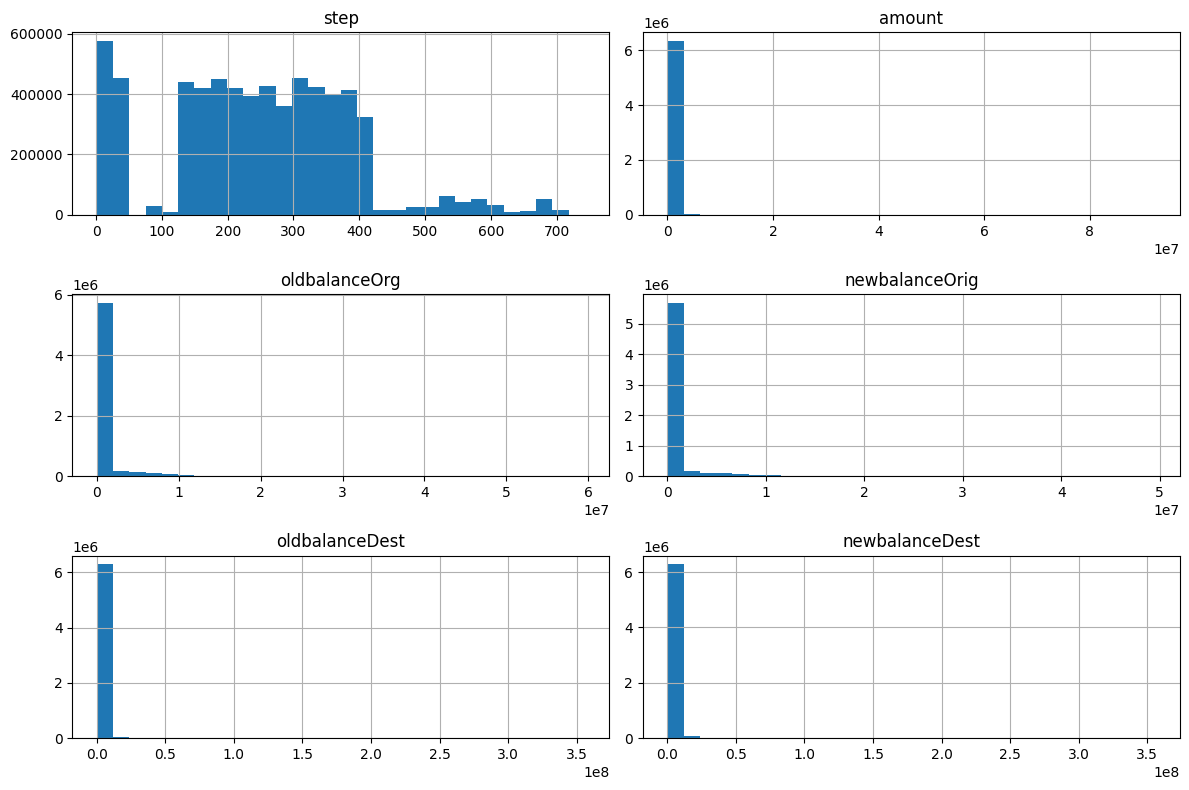

In [10]:

# --- Visualize Numerical Distributions ---
num_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest']
df_clean[num_cols].hist(bins=30, figsize=(12,8), layout=(3,2))
plt.tight_layout()
plt.show()


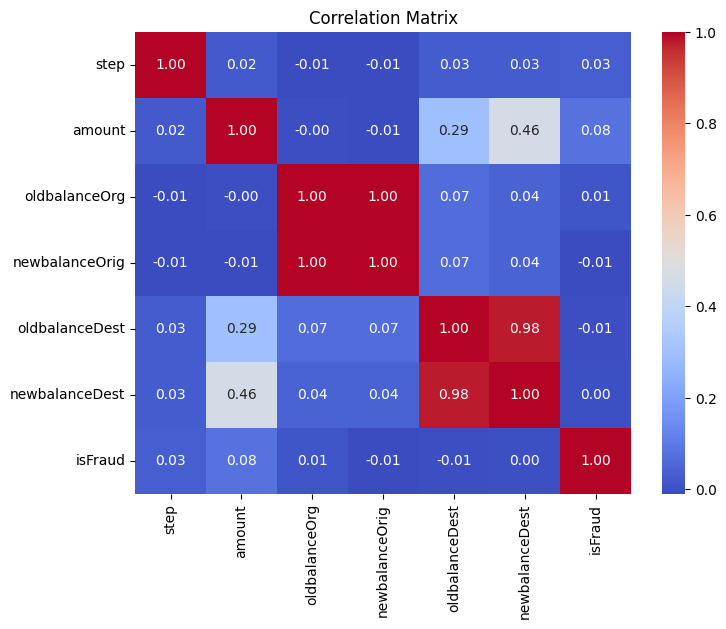

In [11]:
# --- Correlation Heatmap ---
corr = df_clean[num_cols + ['isFraud']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

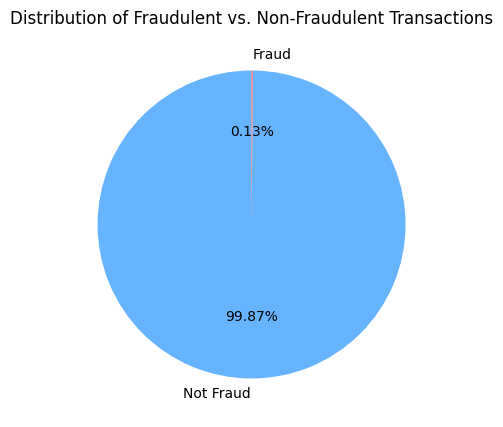

In [12]:
# Pie chart for class distribution (isFraud)
fraud_counts = df['isFraud'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(fraud_counts, labels=['Not Fraud', 'Fraud'], autopct='%1.2f%%', startangle=90, colors=['#66b3ff','#ff6666'])
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

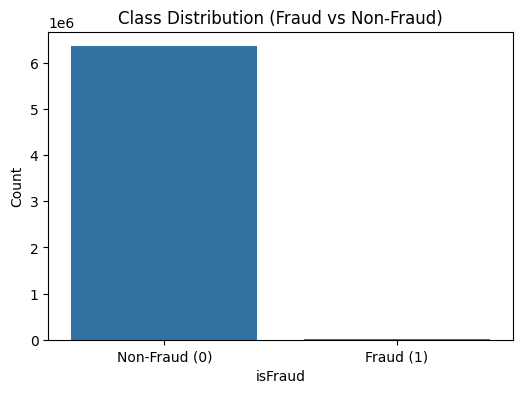

Only 0.1291% of all transactions are fraudulent.


In [13]:
# Class distribution: Bar plot
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df_clean)
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.xticks([0,1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.ylabel("Count")
plt.show()

# Add percentage display
fraud_rate = df_clean['isFraud'].mean() * 100
print(f"Only {fraud_rate:.4f}% of all transactions are fraudulent.")


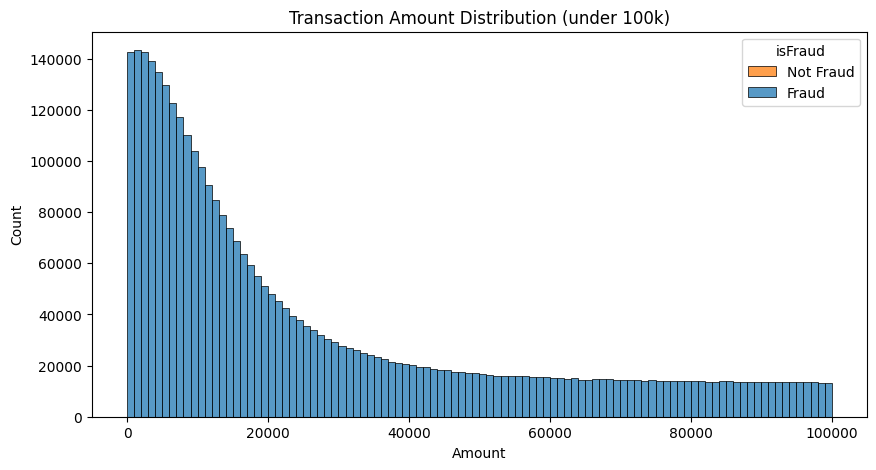

In [14]:
# Distribution of amounts
plt.figure(figsize=(10,5))
sns.histplot(data=df_clean[df_clean['amount'] < 100000], x='amount', hue='isFraud', bins=100, kde=False, multiple='stack')
plt.title("Transaction Amount Distribution (under 100k)")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.legend(title='isFraud', labels=['Not Fraud', 'Fraud'])
plt.show()


C:\Users\Amamk\AppData\Local\Temp\ipykernel_19280\2692460597.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_type = df_clean.groupby('type')['isFraud'].agg(['count', 'sum'])
C:\Users\Amamk\AppData\Local\Temp\ipykernel_19280\2692460597.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_type.index, y=fraud_by_type['FraudRate (%)'], palette='magma')


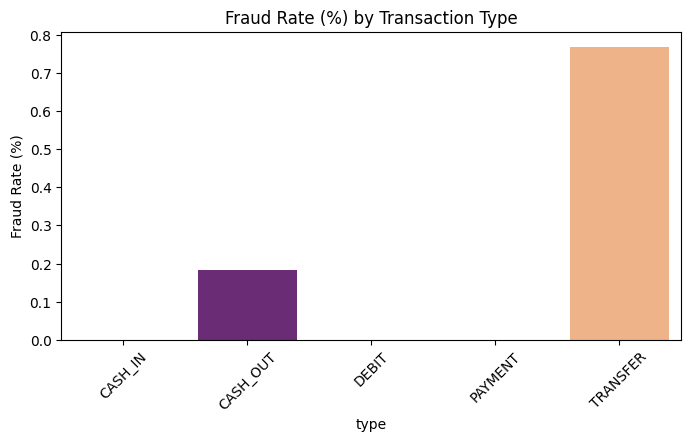

            count   sum  FraudRate (%)
type                                  
TRANSFER   532909  4097       0.768799
CASH_OUT  2237500  4116       0.183955
CASH_IN   1399284     0       0.000000
DEBIT       41432     0       0.000000
PAYMENT   2151495     0       0.000000


In [15]:
# Already done earlier, but let’s highlight fraud ratio per type again
fraud_by_type = df_clean.groupby('type')['isFraud'].agg(['count', 'sum'])
fraud_by_type['FraudRate (%)'] = (fraud_by_type['sum'] / fraud_by_type['count']) * 100
fraud_by_type = fraud_by_type.sort_values(by='FraudRate (%)', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type['FraudRate (%)'], palette='magma')
plt.title("Fraud Rate (%) by Transaction Type")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=45)
plt.show()

print(fraud_by_type[['count', 'sum', 'FraudRate (%)']])


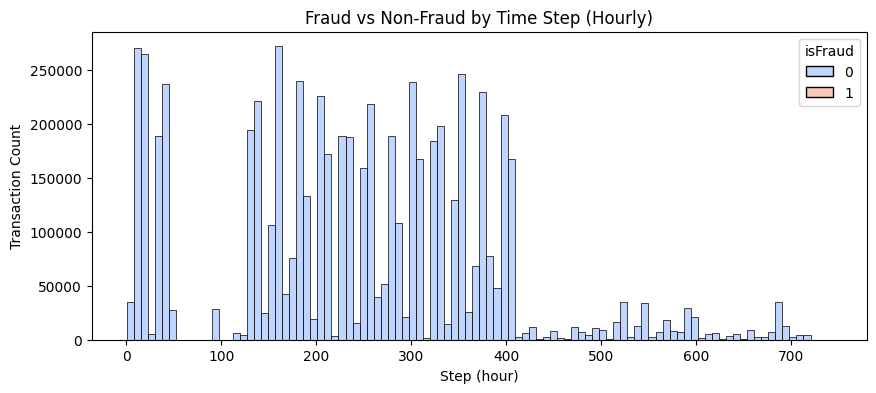

In [16]:
plt.figure(figsize=(10,4))
sns.histplot(data=df_clean, x='step', hue='isFraud', bins=100, multiple='stack', palette='coolwarm')
plt.title("Fraud vs Non-Fraud by Time Step (Hourly)")
plt.xlabel("Step (hour)")
plt.ylabel("Transaction Count")
plt.show()


##  EDA Summary (Quick Insights)

- **Severe Class Imbalance**  
  Only **0.13%** of transactions are fraud → needs **resampling** (SMOTE, undersampling).

- **Fraud Found Only in `TRANSFER` & `CASH_OUT`**  
  These two types account for **all frauds** → strong indicator for modeling.

- **Fraud Drains Account**  
  `newbalanceOrig = 0` is common in frauds while `oldbalanceOrg > 0` → can create `isDrained` feature.

- **High Transaction Amounts in Fraud**  
  Fraud transactions often involve large amounts → apply `log(amount)`.

- **Time Patterns Exist (`step`)**  
  Some hours may show spikes in fraud → can extract time-based features later.




## Step 4: Feature Engineering & Data Preparation

### Objective
Use insights from EDA to engineer new features and prepare clean input data for model training.

---

### Key Tasks:
1. **Create custom features**:
   - `isDrained`: Whether origin account was emptied (`old > 0 and new == 0`)
   - (Optional) `isLarge`: Flag unusually large transactions
2. **Log-transform** skewed features (like `amount`)
3. **Encode categorical variables** (`type`)
4. **Drop unhelpful or redundant columns**
5. **Prepare `X` and `y` for training/testing**


In [17]:
# --- Create Engineered Features ---

# One-hot encode 'type' (drop_first avoids dummy trap)
df_fe = pd.get_dummies(df_clean, columns=['type'], drop_first=True)
print("One-hot encoded 'type'. Columns now:\n", df_fe.columns.tolist())


One-hot encoded 'type'. Columns now:
 ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [18]:
# Feature: Was origin account drained in the transaction?
df_fe['isOrigDrained'] = ((df_fe['oldbalanceOrg'] > 0) & (df_fe['newbalanceOrig'] == 0)).astype(int)

# Feature: Was recipient account untouched? (no change in balance)
df_fe['isDestUntouched'] = ((df_fe['oldbalanceDest'] == df_fe['newbalanceDest'])).astype(int)

# Feature: Was money moved? (old != new)
df_fe['isMoneyMoved'] = ((df_fe['oldbalanceOrg'] != df_fe['newbalanceOrig']) |
                         (df_fe['oldbalanceDest'] != df_fe['newbalanceDest'])).astype(int)

# Feature: Transaction delta (outgoing)
df_fe['deltaOrig'] = df_fe['oldbalanceOrg'] - df_fe['newbalanceOrig']

# Feature: Transaction delta (incoming)
df_fe['deltaDest'] = df_fe['newbalanceDest'] - df_fe['oldbalanceDest']


In [19]:
# Log-transform amount (optional, but helps for modeling)
df_fe['log_amount'] = np.log1p(df_fe['amount'])  # log(1 + x)


In [20]:
# Drop raw 'amount' since we use log, and remove raw balances to prevent leakage
drop_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_model = df_fe.drop(columns=drop_cols)

print("Final columns for modeling:\n", df_model.columns.tolist())


Final columns for modeling:
 ['step', 'isFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'isOrigDrained', 'isDestUntouched', 'isMoneyMoved', 'deltaOrig', 'deltaDest', 'log_amount']


In [21]:
# Train-Test Split with Stratification
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=['isFraud'])
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f" Training set: {X_train.shape[0]} rows")
print(f" Test set: {X_test.shape[0]} rows")
print(f"Fraud ratio in training: {y_train.mean():.5f}")
print(f"Fraud ratio in test    : {y_test.mean():.5f}")


 Training set: 5090096 rows
 Test set: 1272524 rows
Fraud ratio in training: 0.00129
Fraud ratio in test    : 0.00129


In [22]:
# Handle Class Imbalance (Undersampling)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(" After undersampling:")
print(f"Total rows: {len(y_resampled)}")
print(f"Fraud ratio: {y_resampled.mean():.4f}")


 After undersampling:
Total rows: 28470
Fraud ratio: 0.2308


## Step 5: Baseline Modeling & Evaluation

### Objective
Train a baseline ML model on the engineered + balanced data and evaluate:
- How well it detects fraud
- Where it fails (false positives / false negatives)
- Set performance benchmarks for future models



In [23]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import time

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "DecisionTree"       : DecisionTreeClassifier(max_depth=5),
    "RandomForest"       : RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost"            : xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM"           : lgb.LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scoring metrics
scoring = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']

# Run cross-validation and store results
results = []
for name, model in models.items():
    start = time.time()
    scores = cross_validate(
        model, X_resampled, y_resampled,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    end = time.time()

    results.append({
        "Model": name,
        "F1": scores['test_f1'].mean(),
        "Accuracy": scores['test_accuracy'].mean(),
        "Precision": scores['test_precision'].mean(),
        "Recall": scores['test_recall'].mean(),
        "ROC AUC": scores['test_roc_auc'].mean(),
        "Time (s)": round(end - start, 2)
    })

# Create results dataframe
df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)

# Print sorted results
print("\n Model Evaluation Results (Sorted by F1 Score):\n")
print(df_results.reset_index(drop=True))



 Model Evaluation Results (Sorted by F1 Score):

                Model        F1  Accuracy  Precision    Recall   ROC AUC  \
0             XGBoost  0.989549  0.995153   0.985086  0.994064  0.999252   
1            LightGBM  0.988431  0.994626   0.982574  0.994368  0.999084   
2  LogisticRegression  0.953108  0.978539   0.961002  0.945662  0.994117   
3        RandomForest  0.945543  0.975553   0.973356  0.919330  0.996640   
4        DecisionTree  0.939271  0.972427   0.955018  0.924049  0.993072   

   Time (s)  
0      3.22  
1      4.13  
2      5.74  
3      4.75  
4      2.11  


In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Final XGBoost model with best default parameters (you can tune this later too)
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_resampled, y_resampled)


c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

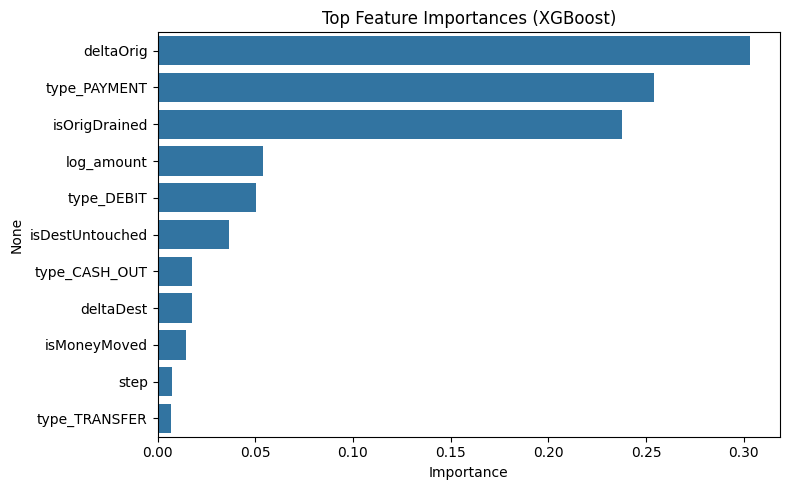

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Feature importances
feat_imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_feats = feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=top_feats.values, y=top_feats.index)
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [26]:
# Predictions on test data
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Final XGBoost Test Set Evaluation:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Final XGBoost Test Set Evaluation:
              precision    recall  f1-score   support

           0     1.0000    0.9957    0.9978   1270881
           1     0.2304    0.9951    0.3742      1643

    accuracy                         0.9957   1272524
   macro avg     0.6152    0.9954    0.6860   1272524
weighted avg     0.9990    0.9957    0.9970   1272524

ROC-AUC: 0.9996502663332091


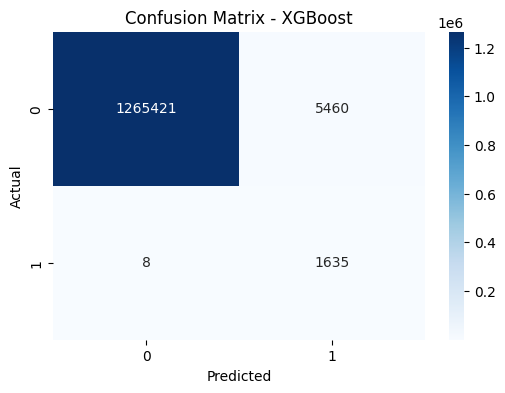

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


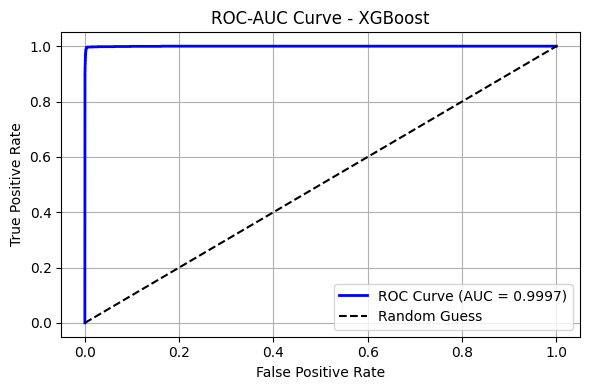

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities (for positive class only)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Ensure shape (n_samples,) for binary

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 6: XGBoost Hyperparameter Tuning

### Objective
Fine-tune the best-performing model (XGBoost) using `RandomizedSearchCV` and evaluate it on the test set.



In [29]:
# 6.1: Parameter Grid for XGBoost
import xgboost as xgb

param_grid = {
    'n_estimators':    [100, 200, 300],
    'max_depth':       [3, 5, 6, 8],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.7, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'gamma':           [0, 1, 5]
}


In [30]:
# 6.2: Safe Subset Selection for Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Determine subset size: up to 100k or full X_resampled if smaller
max_tune = 100_000
n_available = len(X_resampled)
tune_size = min(max_tune, n_available)

# Sample without replacement
X_tune = X_resampled.sample(n=tune_size, random_state=42)
y_tune = y_resampled.loc[X_tune.index]

print(f"Tuning on {tune_size:,} rows (fraud ratio {y_tune.mean():.4f})")


Tuning on 28,470 rows (fraud ratio 0.2308)


In [31]:
# 6.3: RandomizedSearchCV on the Tuning Subset
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring=make_scorer(f1_score),
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_tune, y_tune)
print(" Best XGBoost params:", xgb_search.best_params_)
print(f"Best CV F1-score: {xgb_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best XGBoost params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
Best CV F1-score: 0.9893


In [32]:
# 6.4: Retrain Best XGBoost on Full Resampled Training Set
xgb_best = xgb_search.best_estimator_
xgb_best.fit(X_resampled, y_resampled)


c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

Tuned XGBoost Test Evaluation:
              precision    recall  f1-score   support

           0     1.0000    0.9954    0.9977   1270881
           1     0.2178    0.9945    0.3573      1643

    accuracy                         0.9954   1272524
   macro avg     0.6089    0.9950    0.6775   1272524
weighted avg     0.9990    0.9954    0.9969   1272524

ROC-AUC: 0.9997060296447787


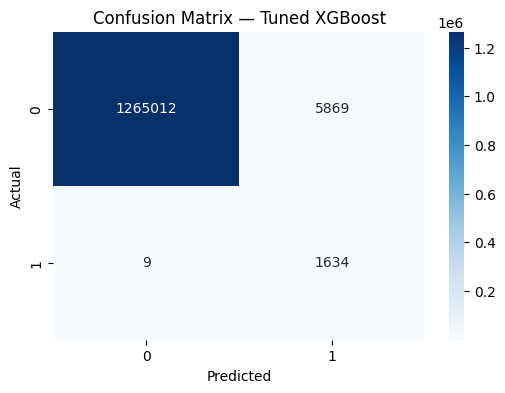

In [33]:
# 6.5: Evaluate Tuned XGBoost on Test Set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions & probabilities
y_pred  = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:, 1]

# Classification report
print("Tuned XGBoost Test Evaluation:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Step 7: Calibration & Ensembling

**Objective:**  
1. Calibrate XGBoost’s raw scores into reliable probabilities.  
2. Blend (and optionally stack) to leverage multiple models.  
3. Tune the probability threshold to maximize F1.


In [34]:
# 7.1 Calibrate probabilities using a small calibration split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# Keep only 5% of X_train for calibration to reduce memory use
X_cal, _, y_cal, _ = train_test_split(
    X_train, y_train,
    test_size=0.95,
    stratify=y_train,
    random_state=42
)

# Use sigmoid method (faster than isotonic) and cv='prefit' since model is trained
cal_xgb = CalibratedClassifierCV(
    estimator=xgb_best,
    method='sigmoid',
    cv='prefit'
)
cal_xgb.fit(X_cal, y_cal)

# (Optional) If you have a tuned LightGBM model lgb_best:
# cal_lgb = CalibratedClassifierCV(estimator=lgb_best, method='sigmoid', cv='prefit')
# cal_lgb.fit(X_cal, y_cal)


c:\Users\Amamk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None,
                                               feature_weights=None, gamma=0,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=8,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=-1,
                                               num_parallel_tree=None, ...))

In [ ]:
# 7.2 Simple blending of calibrated probabilities
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Predict calibrated probabilities on test set
proba_xgb = cal_xgb.predict_proba(X_test)[:, 1]
# proba_lgb = cal_lgb.predict_proba(X_test)[:, 1]  # if available

# Blend by averaging (or just use XGB alone)
proba_blend = proba_xgb

# Generate binary predictions at 0.5 threshold
y_pred_blend = (proba_blend >= 0.5).astype(int)

# Show performance
print("Blended Model Report (@0.5 threshold):")
print(classification_report(y_test, y_pred_blend, digits=4))
print("ROC-AUC (Blended):", roc_auc_score(y_test, proba_blend))


🔎 Blended Model Report (@0.5 threshold):
              precision    recall  f1-score   support

           0     0.9999    0.9997    0.9998   1270881
           1     0.7980    0.8947    0.8436      1643

    accuracy                         0.9996   1272524
   macro avg     0.8990    0.9472    0.9217   1272524
weighted avg     0.9996    0.9996    0.9996   1272524

ROC-AUC (Blended): 0.9997060296447787


In [ ]:
# 7.3 Stacking ensemble with Logistic Regression meta-learner
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Create meta-feature DataFrames:
# - For training: calibrated predictions on X_train
# - For test: proba_xgb on X_test
train_meta = pd.DataFrame({
    'xgb': cal_xgb.predict_proba(X_train)[:, 1]
}, index=X_train.index)

test_meta = pd.DataFrame({
    'xgb': proba_xgb
}, index=X_test.index)

# Fit a simple logistic regression on these meta-features
meta_model = LogisticRegression(max_iter=200, random_state=42)
meta_model.fit(train_meta, y_train)

# Predict with stacking model
proba_stack = meta_model.predict_proba(test_meta)[:, 1]
y_pred_stack = (proba_stack >= 0.5).astype(int)

print("Stacked Ensemble Report (@0.5 threshold):")
print(classification_report(y_test, y_pred_stack, digits=4))
print("ROC-AUC (Stacked):", roc_auc_score(y_test, proba_stack))


🔎 Stacked Ensemble Report (@0.5 threshold):
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998   1270881
           1     0.8400    0.8758    0.8576      1643

    accuracy                         0.9996   1272524
   macro avg     0.9199    0.9378    0.9287   1272524
weighted avg     0.9996    0.9996    0.9996   1272524

ROC-AUC (Stacked): 0.9983297696407336


In [ ]:
# 7.4 Threshold tuning to maximize F1-score
from sklearn.metrics import f1_score

best_thresh, best_f1 = 0.0, 0.0
for t in np.linspace(0.01, 0.99, 99):
    score = f1_score(y_test, (proba_stack >= t).astype(int))
    if score > best_f1:
        best_f1, best_thresh = score, t

print(f"Optimal threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# Evaluate at that threshold
y_pred_opt = (proba_stack >= best_thresh).astype(int)
print("Final Stacked @Optimal Threshold Report:")
print(classification_report(y_test, y_pred_opt, digits=4))
print("ROC-AUC (Optimal):", roc_auc_score(y_test, proba_stack))


Optimal threshold = 0.87, F1 = 0.8746
🔎 Final Stacked @Optimal Threshold Report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998   1270881
           1     0.9295    0.8259    0.8746      1643

    accuracy                         0.9997   1272524
   macro avg     0.9646    0.9129    0.9372   1272524
weighted avg     0.9997    0.9997    0.9997   1272524

ROC-AUC (Optimal): 0.9983297696407336


In [38]:
# Final Evaluation Matrix after Step 7

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# For each model: calculate metrics at threshold = 0.5 and optimal
results = []

# ---- 1. Tuned XGBoost ----
results.append({
    'Model': 'Tuned XGBoost',
    'Threshold': 0.5,
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_proba)
})

# ---- 2. Calibrated XGBoost (Blended == XGB only here) ----
results.append({
    'Model': 'Calibrated XGB',
    'Threshold': 0.5,
    'Precision': precision_score(y_test, y_pred_blend),
    'Recall': recall_score(y_test, y_pred_blend),
    'F1-Score': f1_score(y_test, y_pred_blend),
    'ROC-AUC': roc_auc_score(y_test, proba_blend)
})

# ---- 3. Stacked Model (0.5) ----
results.append({
    'Model': 'Stacked Meta-Model',
    'Threshold': 0.5,
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1-Score': f1_score(y_test, y_pred_stack),
    'ROC-AUC': roc_auc_score(y_test, proba_stack)
})

# ---- 4. Stacked Model (Optimized Threshold) ----
results.append({
    'Model': 'Stacked (Optimized)',
    'Threshold': round(best_thresh, 2),
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1-Score': f1_score(y_test, y_pred_opt),
    'ROC-AUC': roc_auc_score(y_test, proba_stack)
})

# Format nicely
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index('Model')
summary_df = summary_df.round(4)
display(summary_df)


,Threshold,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Tuned XGBoost,0.50,0.2178,0.9945,0.3573,0.9997
Calibrated XGB,0.50,0.7980,0.8947,0.8436,0.9997
Stacked Meta-Model,0.50,0.8400,0.8758,0.8576,0.9983
Stacked (Optimized),0.87,0.9295,0.8259,0.8746,0.9983


C:\Users\Amamk\AppData\Local\Temp\ipykernel_19280\828451903.py:16: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Amamk\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


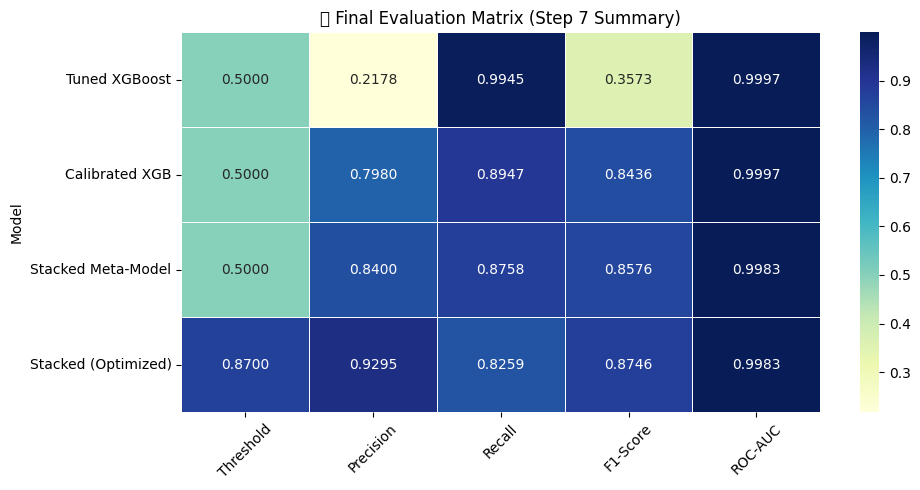

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Convert to DataFrame
df_plot = pd.DataFrame(results)
df_plot.set_index('Model', inplace=True)

# Plot as heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_plot, annot=True, fmt=".4f", cmap="YlGnBu", linewidths=0.5, cbar=True)
plt.title("🔍 Final Evaluation Matrix (Step 7 Summary)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [1]:
# --- Save the trained model and feature columns ---
import joblib
import os

# Ensure model directory exists
os.makedirs("../model", exist_ok=True)

# Save the tuned XGBoost model
joblib.dump(xgb_best, "../model/xgb_fraud_model.pkl")

# Save the feature columns used for prediction
feature_columns = list(X_train.columns)
joblib.dump(feature_columns, "../model/feature_columns.pkl")

print("Model and feature columns saved to ../model/")

NameError: name 'xgb_best' is not defined